# IFS Open Data with Python

This notebook demonstrates how to:

- access **ECMWF IFS open data** using the official client
- download a **small subset** (2 m temperature)
- inspect the GRIB structure
- visualize the field

The same GRIB-based workflow applies to ICON, IFS, and other NWP models.

## Installation

We use the official ECMWF open-data client.

In [1]:
!pip install ecmwf-opendata


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Download IFS 2 m Temperature

We download a **single forecast step** and **two parameters**:

- `2t`  — 2 m temperature
- `msl` — mean sea level pressure

This keeps the file small and suitable for tutorials.

In [2]:
from ecmwf.opendata import Client

client = Client(
    source="ecmwf",   # alternatives: "aws", "azure", "google"
    model="ifs",
)

client.retrieve(
    time=0,           # latest available run
    type="fc",
    step=24,
    param=["2t", "msl"],
    target="ifs_2t.grib2",
)

print("Downloaded ifs_2t.grib2")

To ensure the stability of our systems and to preserve resources for our operational activities (network, compute, etc.), access to the open-data portal is limited to 500 simultaneous connections. This limit helps us guarantee reliable service for our operational users, especially during periods of high demand. For added reliability, the open-data is replicated across AWS, Azure, and Google Cloud. If you experience difficulties accessing the portal directly, you can also retrieve the data from these cloud platforms.


20260119000000-24h-oper-fc.grib2:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

By downloading data from the ECMWF open data dataset, you agree to the terms: Attribution 4.0 International (CC BY 4.0). Please attribute ECMWF when downloading this data.
Downloaded ifs_2t.grib2


## Inspecting the GRIB file

GRIB files are **streams of messages**.
Each message contains one meteorological field.

We explicitly select the `2t` field.

In [3]:
import eccodes

filename = "ifs_2t.grib2"

with open(filename, "rb") as f:
    gid_2t = None
    nmsg = 0

    while True:
        gid = eccodes.codes_grib_new_from_file(f)
        if gid is None:
            break

        nmsg += 1
        short_name = eccodes.codes_get(gid, "shortName")

        print(f"Message {nmsg}: {short_name}")

        if short_name == "2t":
            gid_2t = gid
            break
        else:
            eccodes.codes_release(gid)

    if gid_2t is None:
        raise RuntimeError("2t field not found")

Message 1: msl
Message 2: 2t


## Visualizing the Field

IFS open data uses a **regular latitude–longitude grid**.
The values can be reshaped directly into a 2-D array.

Note:
- grid resolution is fixed by the model
- `figsize` only controls display size

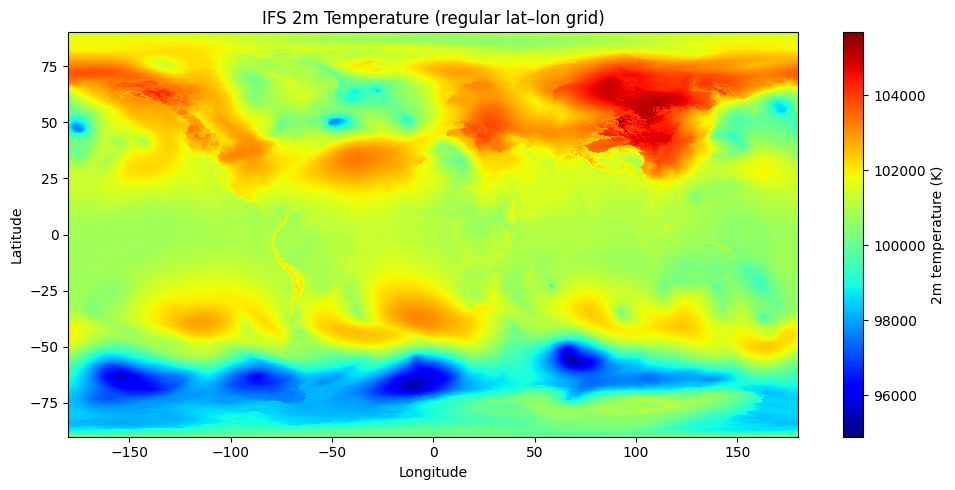

In [4]:
import eccodes
import numpy as np
import matplotlib.pyplot as plt

filename = "ifs_2t.grib2"

# --- read GRIB message ---
with open(filename, "rb") as f:
    gid = eccodes.codes_grib_new_from_file(f)

    values = eccodes.codes_get_array(gid, "values")
    lats   = eccodes.codes_get_array(gid, "latitudes")
    lons   = eccodes.codes_get_array(gid, "longitudes")

    nx = eccodes.codes_get(gid, "Ni")
    ny = eccodes.codes_get(gid, "Nj")

    eccodes.codes_release(gid)

# --- reshape to 2D ---
field = values.reshape(ny, nx)
lat   = lats.reshape(ny, nx)
lon   = lons.reshape(ny, nx)

# --- plot correctly oriented field ---
plt.figure(figsize=(10, 5))

pcm = plt.pcolormesh(
    lon,
    lat,
    field,
    cmap="jet",
    shading="auto"
)

plt.colorbar(pcm, label="2m temperature (K)")
plt.title("IFS 2m Temperature (regular lat–lon grid)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


### Cartopy and map projections

Cartopy is a Python library for geospatial data visualisation that builds on
`matplotlib` and provides explicit handling of coordinate reference systems
(CRS) and map projections. It separates the numerical data coordinates from
the projection used for display, allowing meteorological fields to be plotted
consistently on maps while preserving their original grid definition.

In this workflow, IFS data are already defined on a regular latitude–longitude
grid, so the appropriate CRS is `PlateCarree`. No reprojection of the field
values is required; Cartopy is used solely to provide a projection-aware axis
and to overlay geographic features such as coastlines and borders. The data
arrays and plotting call remain unchanged, apart from specifying the CRS
transform.


### Cartopy installation

Cartopy relies on native geospatial libraries (PROJ, GEOS).
Installation therefore depends on the platform.

**Linux (apt-based):**
```bash
sudo apt install libproj-dev proj-data proj-bin libgeos-dev
pip install cartopy
```

**MAC**
```basj
brew install proj geos
pip install cartopy
````

/Users/michel/Desktop/src/e-ai_ml2/aienv/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/michel/Desktop/src/e-ai_ml2/aienv/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/michel/Desktop/src/e-ai_ml2/aienv/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


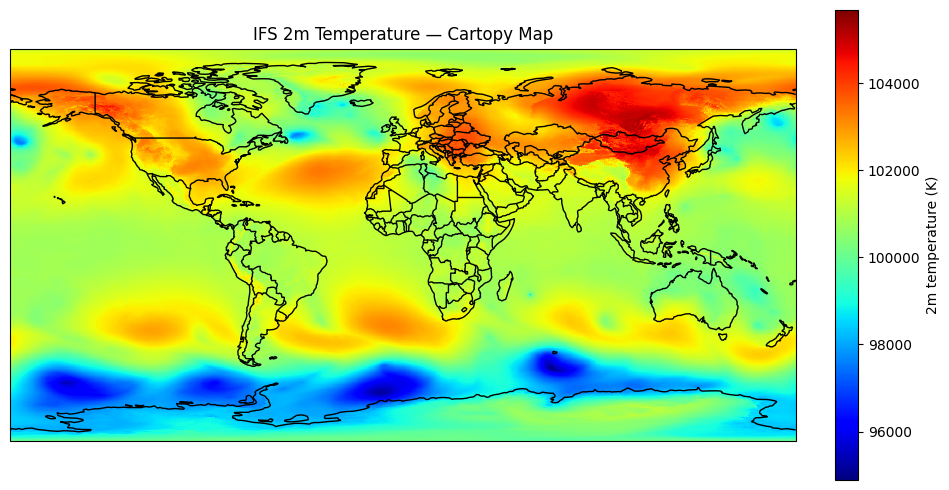

In [5]:
import eccodes
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

filename = "ifs_2t.grib2"

# --- read GRIB message ---
with open(filename, "rb") as f:
    gid = eccodes.codes_grib_new_from_file(f)

    values = eccodes.codes_get_array(gid, "values")
    lats   = eccodes.codes_get_array(gid, "latitudes")
    lons   = eccodes.codes_get_array(gid, "longitudes")

    nx = eccodes.codes_get(gid, "Ni")
    ny = eccodes.codes_get(gid, "Nj")

    eccodes.codes_release(gid)

# --- reshape to 2D ---
field = values.reshape(ny, nx)
lat   = lats.reshape(ny, nx)
lon   = lons.reshape(ny, nx)

# ======================================================
# 2) Cartopy map plot
# ======================================================
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor="lightgray")

pcm = ax.pcolormesh(
    lon, lat, field,
    transform=ccrs.PlateCarree(),
    cmap="jet",
    shading="auto"
)

cbar = plt.colorbar(pcm, ax=ax, pad=0.04)
cbar.set_label("2m temperature (K)")

ax.set_title("IFS 2m Temperature — Cartopy Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()
